# A Very Basic Simulation of _Quacks of Quedlinburg_

In [1]:
from quacks import Ingredient, Bag
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", palette=None)

In [2]:
def generate_statistics(bag, num_rounds=10000):
    """
    Runs simulated rounds for a given bag of ingredients for both playing safe and playing until exploding 
    and plots the distribution of results.
    
    Parameters
    ----------
    bag : Bag
        An instance of the Bag class with the player's ingredients.
    num_rounds: int
        The number of rounds to be simulated. By default set to 10000.
        
    Returns
    -------
    None
    """
    print(f'Running {num_rounds:,} rounds for a bag...\n')
    bag.print_ingredients('master')
    
    exploded_round_values = []
    for i in range(num_rounds):
        temp_round_values = bag.simulate_round()
        exploded_round_values.append(temp_round_values[0])
    print(f'\nExploded Maximum score: {np.max(exploded_round_values)}')
    print(f'Exploded Average score: {np.mean(exploded_round_values):.2f}')
    
    safe_round_values = []
    for i in range(num_rounds):
        temp_round_values = bag.simulate_round(stop_before_explosion=True)
        safe_round_values.append(temp_round_values[0])
    print(f'\nSafe Maximum score: {np.max(safe_round_values)}')
    print(f'Safe Average score: {np.mean(safe_round_values):.2f}')
    
    exploded_df = pd.DataFrame({'value': exploded_round_values, 'run_type': 'exploded'})
    safe_df = pd.DataFrame({'value': safe_round_values, 'run_type': 'safe'})
    
    sns.histplot(
        data=pd.concat([exploded_df, safe_df]), 
        x='value', 
        hue='run_type',
        element='step',
        bins=np.max(exploded_round_values),
        discrete=True
    )
    plt.xlabel('Spaces Moved')
    plt.ylabel('Simulated Occurrences')
    plt.title('Playing Safe vs Picking Until Exploding:\nHow Often Will You Move X Spaces?')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', labels=['Play Safe', 'Explode'], title='Strategy')

## Looking at Some Bags of Ingredients

In [3]:
my_bag = Bag()

### Starting Ingredients

Running 10,000 rounds for a bag...

Showing the master set of ingredients:
    white: [1, 1, 1, 1, 2, 2, 3]
    orange: [1]
    green: [1]

Exploded Maximum score: 12
Exploded Average score: 9.76

Safe Maximum score: 9
Safe Average score: 6.78


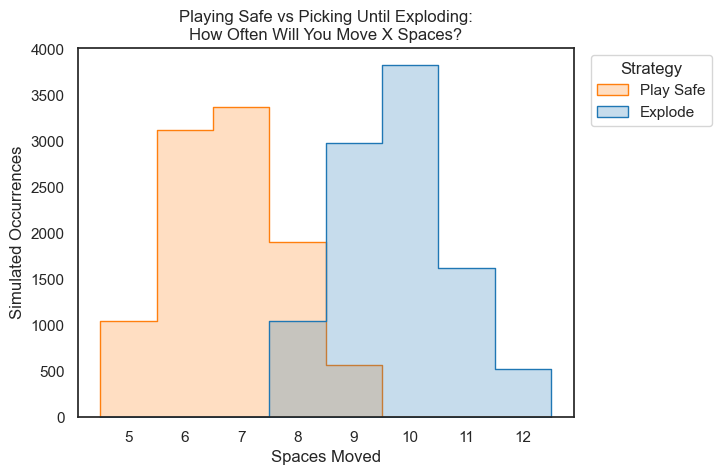

In [4]:
generate_statistics(my_bag)

### Should I Add Four Twos or Two Fours?

In [5]:
my_bag.return_to_baseline()
my_bag.add_ingredient('green', 2)
my_bag.add_ingredient('green', 2)
my_bag.add_ingredient('green', 2)
my_bag.add_ingredient('green', 2)

Running 10,000 rounds for a bag...

Showing the master set of ingredients:
    white: [1, 1, 1, 1, 2, 2, 3]
    orange: [1]
    green: [1, 2, 2, 2, 2]

Exploded Maximum score: 20
Exploded Average score: 15.01

Safe Maximum score: 17
Safe Average score: 10.43


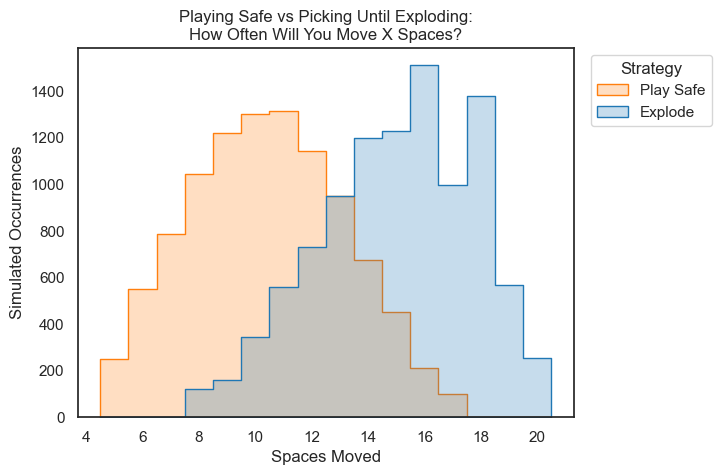

In [6]:
generate_statistics(my_bag)

In [7]:
my_bag.return_to_baseline()
my_bag.add_ingredient('green', 4)
my_bag.add_ingredient('green', 4)

Running 10,000 rounds for a bag...

Showing the master set of ingredients:
    white: [1, 1, 1, 1, 2, 2, 3]
    orange: [1]
    green: [1, 4, 4]

Exploded Maximum score: 20
Exploded Average score: 14.96

Safe Maximum score: 17
Safe Average score: 10.37


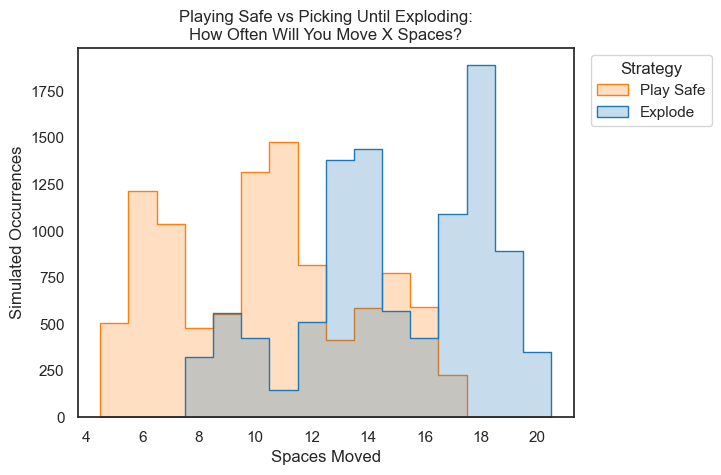

In [8]:
generate_statistics(my_bag)

The average score is the same but the distributions are very different!